In [1]:
import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
sess = tf.Session()
min_word_freq = 5
rnn_size = 128
embedding_size = 100
epochs = 10
batch_size = 100
learning_rate = 0.001
training_seq_len = 50
embedding_size = rnn_size
save_every = 500
eval_every = 50
prime_texts = ['thou art more', 'to be or not to', 'wherefore art thou']

In [3]:
data_dir = 'temp'
data_file = 'shakespeare.txt'
model_path = 'shakespeare_model'
full_model_dir = os.path.join(data_dir, model_path)
punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])

In [4]:
if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
print('Loading Shakespeare Data')
warnings.filterwarnings("ignore")
if not os.path.isfile(os.path.join(data_dir, data_file)):
    print('Not found, downloading Shakespeare texts from www.gutenberg.org')
    shakespeare_url = 'http://www.gutenberg.org/cache/epub/100/pg100.txt'
    response = requests.get(shakespeare_url)
    shakespeare_file = response.content
    s_text = shakespeare_file.decode('utf-8')
    s_text = s_text[7675:]
    s_text = s_text.replace('\r\n', '')
    s_text = s_text.replace('\n', '')
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        out_conn.write(s_text)
else:
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        s_text = file_conn.read().replace('\n', '')

Loading Shakespeare Data
Not found, downloading Shakespeare texts from www.gutenberg.org


In [5]:
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text ).strip().lower()

In [6]:
def build_vocab(text, min_word_freq):
    word_counts = collections.Counter(text.split(' '))
    word_counts = {key:val for key, val in word_counts.items() if val>min_word_freq}
    words = word_counts.keys()
    vocab_to_ix_dict = {key:(ix+1) for ix, key in enumerate(words)}
    vocab_to_ix_dict['unknown']=0
    ix_to_vocab_dict = {val:key for key,val in vocab_to_ix_dict.items()}
    return(ix_to_vocab_dict, vocab_to_ix_dict)
ix2vocab, vocab2ix = build_vocab(s_text, min_word_freq)
vocab_size = len(ix2vocab) + 1
print('Vocabulary Length = {}'.format(vocab_size))
assert(len(ix2vocab) == len(vocab2ix))

Vocabulary Length = 8009


In [7]:
s_text_words = s_text.split(' ')
s_text_ix = []
for ix, x in enumerate(s_text_words):
    try:
        s_text_ix.append(vocab2ix[x])
    except:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)

In [8]:
class LSTM_Model():
    def __init__(self, embedding_size, rnn_size, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        self.embedding_size = embedding_size
        self.rnn_size = rnn_size
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate

        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len

        self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.rnn_size)
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)

        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])

        with tf.variable_scope('lstm_vars'):
            W = tf.get_variable('W', [self.rnn_size, self.vocab_size], tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, tf.constant_initializer(0.0))
            embedding_mat = tf.get_variable('embedding_mat', [self.vocab_size, self.embedding_size],
                                            tf.float32, tf.random_normal_initializer())
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
        def inferred_loop(prev, count):
            prev_transformed = tf.matmul(prev, W) + b
            prev_symbol = tf.stop_gradient(tf.argmax(prev_transformed, 1))
            output = tf.nn.embedding_lookup(embedding_mat, prev_symbol)
            return(output)
        decoder = tf.contrib.legacy_seq2seq.rnn_decoder
        outputs, last_state = decoder(rnn_inputs_trimmed,
                                      self.initial_state,
                                      self.lstm_cell,
                                      loop_function=inferred_loop if infer_sample else None)
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
        self.logit_output = tf.matmul(output, W) + b
        self.model_output = tf.nn.softmax(self.logit_output)
        loss_fun = tf.contrib.legacy_seq2seq.sequence_loss_by_example
        loss = loss_fun([self.logit_output],[tf.reshape(self.y_output, [-1])],
                [tf.ones([self.batch_size * self.training_seq_len])],
                self.vocab_size)
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state
        gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    def sample(self, sess, words=ix2vocab, vocab=vocab2ix, num=10, prime_text='thou art'):
        state = sess.run(self.lstm_cell.zero_state(1, tf.float32))
        word_list = prime_text.split()
        for word in word_list[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)
        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            word = words[sample]
            out_sentence = out_sentence + ' ' + word
        return(out_sentence)

In [9]:
lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                        training_seq_len, vocab_size)
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    test_lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                                 training_seq_len, vocab_size, infer_sample=True)

In [10]:
saver = tf.train.Saver(tf.global_variables())
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
batches = np.array_split(s_text_ix, num_batches)
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
train_loss = []
iteration_count = 1
for epoch in range(epochs):
    random.shuffle(batches)
    targets = [np.roll(x, -1, axis=1) for x in batches]
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
        c, h = lstm_model.initial_state
        training_dict[c] = state.c
        training_dict[h] = state.h
        temp_loss, state, _ = sess.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_op],
                                       feed_dict=training_dict)
        train_loss.append(temp_loss)
        if iteration_count % 10 == 0:
            summary_nums = (iteration_count, epoch+1, ix+1, num_batches+1, temp_loss)
            print('Iteration: {}, Epoch: {}, Batch: {} out of {}, Loss: {:.2f}'.format(*summary_nums))
        if iteration_count % save_every == 0:
            model_file_name = os.path.join(full_model_dir, 'model')
            saver.save(sess, model_file_name, global_step = iteration_count)
            print('Model Saved To: {}'.format(model_file_name))
            dictionary_file = os.path.join(full_model_dir, 'vocab.pkl')
            with open(dictionary_file, 'wb') as dict_file_conn:
                pickle.dump([vocab2ix, ix2vocab], dict_file_conn)
        if iteration_count % eval_every == 0:
            for sample in prime_texts:
                print(test_lstm_model.sample(sess, ix2vocab, vocab2ix, num=10, prime_text=sample))
        iteration_count += 1

Starting Epoch #1 of 10.
Iteration: 10, Epoch: 1, Batch: 10 out of 182, Loss: 9.73
Iteration: 20, Epoch: 1, Batch: 20 out of 182, Loss: 9.16
Iteration: 30, Epoch: 1, Batch: 30 out of 182, Loss: 8.70
Iteration: 40, Epoch: 1, Batch: 40 out of 182, Loss: 8.32
Iteration: 50, Epoch: 1, Batch: 50 out of 182, Loss: 8.23
thou art more suit trouble satisfy utt'red trouble opposed unarm'd unarm'd alms to
to be or not to the
wherefore art thou respects grave wilt cooling strato panthino grief and
Iteration: 60, Epoch: 1, Batch: 60 out of 182, Loss: 7.91
Iteration: 70, Epoch: 1, Batch: 70 out of 182, Loss: 7.69
Iteration: 80, Epoch: 1, Batch: 80 out of 182, Loss: 7.49
Iteration: 90, Epoch: 1, Batch: 90 out of 182, Loss: 7.37
Iteration: 100, Epoch: 1, Batch: 100 out of 182, Loss: 7.09
thou art more staves show 1 for your
to be or not to the
wherefore art thou art protest hood hood us and
Iteration: 110, Epoch: 1, Batch: 110 out of 182, Loss: 6.88
Iteration: 120, Epoch: 1, Batch: 120 out of 182, Los

Iteration: 1040, Epoch: 6, Batch: 135 out of 182, Loss: 5.63
Iteration: 1050, Epoch: 6, Batch: 145 out of 182, Loss: 5.88
thou art more than our
to be or not to the
wherefore art thou shalt be
Iteration: 1060, Epoch: 6, Batch: 155 out of 182, Loss: 5.90
Iteration: 1070, Epoch: 6, Batch: 165 out of 182, Loss: 5.90
Iteration: 1080, Epoch: 6, Batch: 175 out of 182, Loss: 6.00
Starting Epoch #7 of 10.
Iteration: 1090, Epoch: 7, Batch: 4 out of 182, Loss: 5.93
Iteration: 1100, Epoch: 7, Batch: 14 out of 182, Loss: 6.11
thou art more than
to be or not to the
wherefore art thou shalt not be
Iteration: 1110, Epoch: 7, Batch: 24 out of 182, Loss: 5.81
Iteration: 1120, Epoch: 7, Batch: 34 out of 182, Loss: 5.84
Iteration: 1130, Epoch: 7, Batch: 44 out of 182, Loss: 6.15
Iteration: 1140, Epoch: 7, Batch: 54 out of 182, Loss: 6.17
Iteration: 1150, Epoch: 7, Batch: 64 out of 182, Loss: 5.85
thou art more than that
to be or not to the
wherefore art thou hast thy
Iteration: 1160, Epoch: 7, Batch: 74 

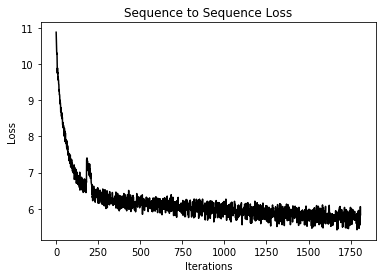

In [12]:
plt.plot(train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()